In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import random
from keras import models, layers
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import tensorflow as tf


MAX_TRAIN_STEPS = 10
MAX_VAL_STEPS = 10
MAX_EPOCHS = 10

LIMIT = int(1e2)

BASE_DIR = 'airbus-ship-detection/'

TRAIN_PATH = BASE_DIR + 'train_v2/'
TEST_PATH = BASE_DIR + 'test_v2/'
MASKS_PATH = BASE_DIR + 'train_ship_segmentations_v2.csv'


Sz of train dataset : 192556 |['4a5b2532e.jpg', '34b973fb0.jpg', '133b13bda.jpg', '5ecf4344b.jpg', '96f178a96.jpg', 'b5b6373bb.jpg', 'a78a82b25.jpg', 'c50310bc5.jpg', '531054a2b.jpg', '4235d2d8f.jpg', 'b0f4d07ed.jpg', '0deadf346.jpg', '2a9e2ac00.jpg', 'fa5c0c8b7.jpg', '6098e0ec7.jpg', '46d5ace64.jpg', '4790fd62c.jpg', 'cb9e718ee.jpg', '7ae2572ee.jpg', '6076a2546.jpg', 'c5ab26d22.jpg', '271956629.jpg', '5d8c071c4.jpg', '567261abb.jpg', 'a5ca05522.jpg', '448a95362.jpg', 'bad7a9587.jpg', 'a0c72d497.jpg', '75f2305a4.jpg', 'f56fa13de.jpg', '3cdc5adb9.jpg', '944c752de.jpg', '0af151ad2.jpg', '66a93d57b.jpg', '64c3335d0.jpg', '98f33d745.jpg', '3cf656feb.jpg', '938c8d3d3.jpg', '7ef0386e6.jpg', '7e86c4e26.jpg', '2880e817b.jpg', '84eed2fa0.jpg', 'ffd6a9ac7.jpg', '10dfa91c8.jpg', 'ca18c4ece.jpg', 'bc5a522cb.jpg', '6e7ebfd3f.jpg', '83aadba9d.jpg', '804f0977d.jpg', '65ffb677f.jpg', '877c2026b.jpg', '673e1b210.jpg', 'dcbd287ff.jpg', '9de779fbe.jpg', 'c9b34541b.jpg', 'b17ae157f.jpg', '1d7ff6175.jpg', 

In [ ]:
train = os.listdir(TRAIN_PATH)
test = os.listdir(TEST_PATH)

print(f'Sz of train dataset : {len(train)} |{train[:LIMIT]}')
print(f'Sz of test dataset : {len(test)} |{test[:LIMIT]}')

In [2]:
masks = pd.read_csv(MASKS_PATH)
masks

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [3]:
print(f'Total amount of unique photos: {len(masks.ImageId.unique())}')

Total amount of unique photos: 192556


In [4]:


def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape=(768,768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [5]:
def concat_mask(mask_list):
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

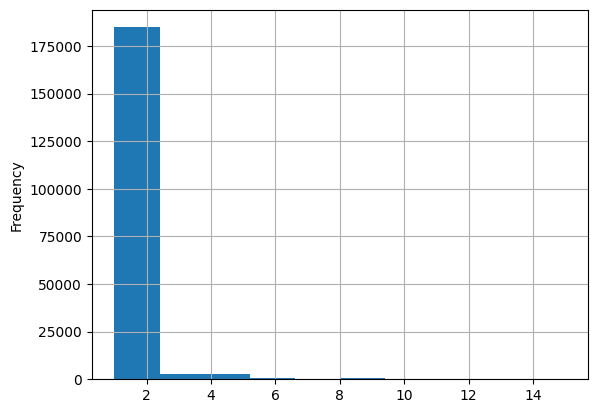

In [6]:
masks.ImageId.value_counts().plot.hist().grid(True)

In [7]:
ships = masks.copy()
ships['Ships'] = ships['EncodedPixels'].notnull().astype(int)
ships = ships.groupby('ImageId').sum().reset_index()

ships.EncodedPixels = ships.EncodedPixels.apply(lambda x: x if x != 0 else '')
ships


,ImageId,EncodedPixels,Ships
0,00003e153.jpg,,0
1,0001124c7.jpg,,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,0001b1832.jpg,,0
...,...,...,...
192551,fffedbb6b.jpg,,0
192552,ffff2aa57.jpg,,0
192553,ffff6e525.jpg,,0
192554,ffffc50b4.jpg,,0


In [8]:
masks.fillna('', inplace = True)
masks

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,
231719,ffff2aa57.jpg,
231720,ffff6e525.jpg,
231721,ffffc50b4.jpg,


In [9]:
train_ships, valid_ships = train_test_split(ships, test_size = 0.25, stratify = ships.Ships)
train_ships

,ImageId,EncodedPixels,Ships
129740,ac8321b19.jpg,,0
140080,ba1d1d16a.jpg,190823 2 191587 6 192352 10 193116 14 193880 1...,1
8198,0ae4292b0.jpg,,0
91574,799ef20a0.jpg,,0
180629,f03727949.jpg,132485 1 133252 4 134020 6 134787 9 135555 11 ...,1
...,...,...,...
111259,93ef3e19c.jpg,,0
17302,1703451bc.jpg,,0
167444,deb556038.jpg,,0
156351,d0064ce72.jpg,357528 3 358296 7 359064 10 359831 11 360599 1...,1


In [10]:
def undersample(df: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df[df.Ships == 0].sample(n = 25000, random_state = 42), df[df.Ships != 0]])

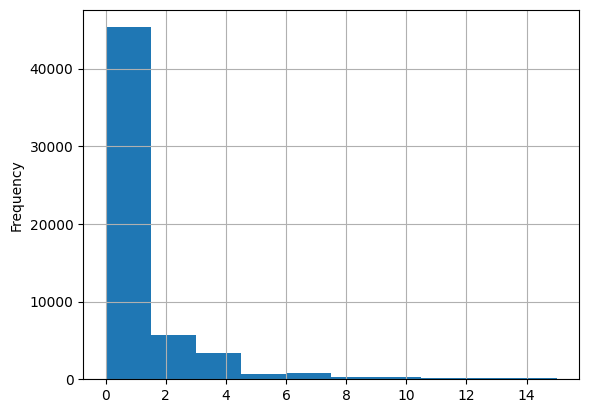

In [11]:
train_ships, valid_ships = undersample(train_ships), undersample(valid_ships)
train_ships.Ships.plot.hist().grid(True)

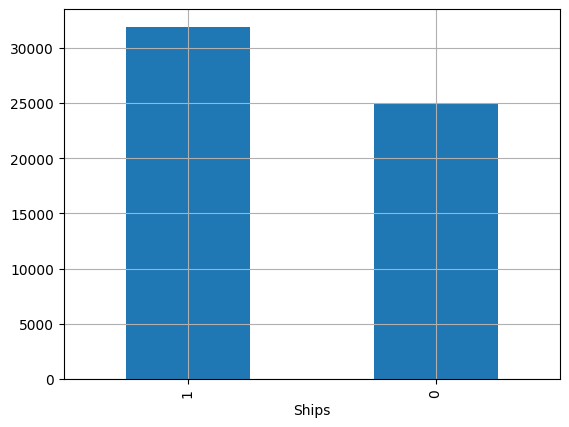

In [12]:


(train_ships.Ships > 0).astype(int).value_counts().plot.bar().grid(True)

In [13]:
train_ships.shape, valid_ships.shape

((56917, 3), (35639, 3))

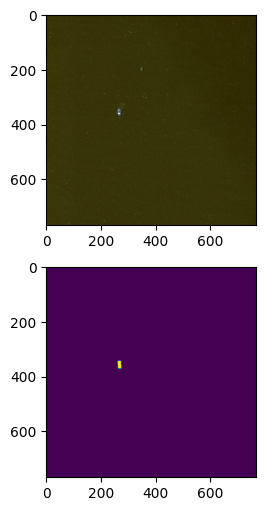

In [14]:


random_img = random.choice(os.listdir(TRAIN_PATH))

test_masks = masks[masks.ImageId == random_img]
msk = concat_mask(list(test_masks.EncodedPixels))

img = cv.imread(TRAIN_PATH + random_img)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].imshow(img)
axes[1].imshow(msk)

In [15]:


def UnetCNN(input_size = (256, 256, 3)):
    inputs = layers.Input(input_size)

    C1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    C1 = layers.Dropout(0.1)(C1)
    C1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C1)
    P1 = layers.MaxPooling2D((2, 2))(C1)

    C2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P1)
    C2 = layers.Dropout(0.1)(C2)
    C2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C2)
    P2 = layers.MaxPooling2D((2, 2))(C2)

    C3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P2)
    C3 = layers.Dropout(0.2)(C3)
    C3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C3)
    P3 = layers.MaxPooling2D((2, 2))(C3)

    C4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P3)
    C4 = layers.Dropout(0.2)(C4)
    C4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C4)
    P4 = layers.MaxPooling2D(pool_size=(2, 2))(C4)

    C5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P4)
    C5 = layers.Dropout(0.3)(C5)
    C5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C5)

    U6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(C5)
    U6 = layers.concatenate([U6, C4])
    C6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U6)
    C6 = layers.Dropout(0.2)(C6)
    C6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C6)

    U7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(C6)
    U7 = layers.concatenate([U7, C3])
    C7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U7)
    C7 = layers.Dropout(0.2)(C7)
    C7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C7)

    U8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(C7)
    U8 = layers.concatenate([U8, C2])
    C8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U8)
    C8 = layers.Dropout(0.1)(C8)
    C8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C8)

    U9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(C8)
    U9 = layers.concatenate([U9, C1], axis=3)
    C9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U9)
    C9 = layers.Dropout(0.1)(C9)
    C9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C9)

    D = layers.Conv2D(1, (1, 1), activation='sigmoid')(C9)
    
    seg_model = models.Model(inputs=[inputs], outputs=[D])
    
    return seg_model

built_model = UnetCNN()
built_model.summary()

2024-07-14 01:15:00.235816: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-14 01:15:00.300873: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-14 01:15:00.465854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 01:15:00.556640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 01:15:00.557149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 01:15:00.672125: I tensorflow/core/platform/cpu_feature_guard.cc:

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:


class BatchData():
    def __init__(self, batch_sz, imgs, masks) -> None:
        self.imgs = imgs
        self.masks = masks
        self.batch_sz = batch_sz

    def __len__(self):
        return math.ceil(len(self.images) / self.batch_size)


    def __getitem__(self, idx):
        sz = idx * self.batch_sz
        sz_next = (idx + 1) * self.batch_sz
        batch_imgs = self.imgs[sz:sz_next]
        
        # Reading images
        imgs = np.array([
            cv.resize(cv.imread(os.path.join(TRAIN_PATH, img_name)), (256, 256)) / 255.0
            for img_name in batch_imgs
        ], dtype=np.float32)

        msks = np.array([
            cv.resize(concat_mask(self.masks[self.masks['ImageId'] == img_name]['EncodedPixels']), (256, 256))
            for img_name in batch_imgs
        ], dtype=np.float32)
        msks = np.expand_dims(msks, axis=-1)
        
        return imgs, msks




In [17]:
BATCH_SIZE = 16
train_batch = BatchData(BATCH_SIZE, train_ships['ImageId'], masks)
valid_batch = BatchData(BATCH_SIZE, valid_ships['ImageId'], masks)

img, mask = next(iter(train_batch))
img.shape, mask.shape

((16, 256, 256, 3), (16, 256, 256, 1))

In [18]:

def batch_data_generator(batch_data_instance):
    for imgs, msks in batch_data_instance:
        yield imgs, msks

train_df = tf.data.Dataset.from_generator(
    lambda: batch_data_generator(train_batch),
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, 256, 256, 1), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

valid_df = tf.data.Dataset.from_generator(
    lambda: batch_data_generator(valid_batch),
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, 256, 256, 1), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

In [19]:


# Path to save intermediate and model weights
weight_path='{}.weights.h5'.format('seg_model')

# Save the model after each epoch if the validation loss improved
checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

# Reduce the learning rate when the metric has stopped improving
reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)

# Stop training when the validation loss has stopped improving
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15)

# Keep track of training history by creating a callbacks list
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [20]:


def dice_coef(y_true, y_pred, smooth = 1):
    # Reshape the true masks
    y_true = K.cast(y_true, 'float32')
    # Calculate the intersection between predicted and true masks
    intersection = K.sum(y_true * y_pred, axis = [1, 2, 3])
    # Calculate the union of predicted and true masks
    union = K.sum(y_true, axis = [1, 2, 3]) + K.sum(y_pred, axis = [1, 2, 3])
    # Calculate the Dice coefficient
    return K.mean((2. * intersection + smooth) / (union + smooth), axis = 0)

def dice_p_bce(in_gt, in_pred):
    # Combine binary cross-entropy and negative Dice coefficient
    return 1e-3 * binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    # Calculate the true positive rate
    return K.sum(K.flatten(y_true) * K.flatten(K.round(y_pred))) / K.sum(y_true)

def precision(y_true, y_pred):
    # Calculate the precision rate (the proportion of true positive predictions
    # out of all positive predictions)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    # Calculate the recall rate (the proportion of true positive predictions 
    # out of all positive samples)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (total_positives + K.epsilon())

def specificity(y_true, y_pred):
    # Calculate the specificity rate (the proportion of true negative 
    # predictions out of all negative samples)
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    total_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (total_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    # Calculate the F1 score (harmonic mean of precision and recall)
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))


# Compile the model with the Adam optimizer,
# binary cross-entropy and the custom metrics
built_model.compile(optimizer = "adam", loss = dice_p_bce, 
            metrics = ['binary_accuracy',
                       dice_coef, 
                       true_positive_rate, 
                       precision, 
                       recall, 
                       specificity, 
                       f1_score
                       ]
                       ) 

In [27]:

built_model.fit(
    train_df,
    validation_data = valid_df,
    callbacks = callbacks_list,
    verbose = 1,
    epochs = MAX_EPOCHS,
    steps_per_epoch = MAX_TRAIN_STEPS,
    validation_steps = MAX_VAL_STEPS
    )

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 1.0000 - dice_coef: 1.0000 - f1_score: 0.0000e+00 - loss: -1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - specificity: 1.0000 - true_positive_rate: nan
Epoch 1: val_dice_coef did not improve from 1.00000
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - binary_accuracy: 1.0000 - dice_coef: 1.0000 - f1_score: 0.0000e+00 - loss: -1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - specificity: 1.0000 - true_positive_rate: nan - val_binary_accuracy: 1.0000 - val_dice_coef: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: -1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_true_positive_rate: nan - learning_rate: 0.0010
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 1.0000 - dice_coef: 1.0000 - f1_score: 0.0000e+00 - loss: -1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - specificity: 1.0000 - true_positive_rate: nan
Epoch 2: val_dice_coef did not improve from 1

In [28]:
built_model.load_weights(weight_path)
built_model.save('model.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'seg_model.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)